In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression, DeepKNN,CustomWrapper
from tqdm.notebook import tqdm, trange

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")
plt.style.use('seaborn-darkgrid')

GPU detected is GeForce GTX 970


In [2]:
id_col_db = {'A_C_OF_ALPHA':["sample_id"],
             'A_C_OF_SIWARE':[],
             'A_AL_RT':[],
             'PLN7':["db_id", "sample_id"],
             'mango_684_990': ['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]
            }

output_col_db= {'A_C_OF_ALPHA':None,
             'A_C_OF_SIWARE':None,
             'A_AL_RT':None,
             'PLN7':None,
             'mango_684_990': ['DM']
            }

kNN_k= {'A_C_OF_ALPHA':'knn_unif_n=20',
             'A_C_OF_SIWARE':'knn_unif_n=20',
             'A_AL_RT':'knn_unif_n=20',
             'PLN7':'knn_unif_n=20',
             'mango_684_990': 'knn_unif_n=20'
            }

LWR_k= {'A_C_OF_ALPHA':'lwr_k=1000',
             'A_C_OF_SIWARE':'lwr_k=1000',
             'A_AL_RT':'lwr_k=700',
             'PLN7':'lwr_k=1000',
             'mango_684_990': 'lwr_k=1000'
            }


In [3]:
#setup input and output formats, load data

file_name = "A_C_OF_ALPHA.csv"
dataset_name = re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

base_dir = Path("D:/workspace/lazydeep/experiments/")
lr_dir = base_dir/"2.01"/dataset_name #1.02 / 2.01
lwr_dir = base_dir/"2.03"/dataset_name #1.05 / 2.03
knn_dir = base_dir/"2.02"/dataset_name #1.04 / 2.02


In [4]:
scores_cv_lwr = pd.read_csv(lwr_dir /"scores.csv")
scores_cv_knn = pd.read_csv(knn_dir /"scores.csv")
scores_cv_lr = pd.read_csv(lr_dir /"scores.csv")

scores_test_lwr = pd.read_csv(lwr_dir /"test_scores.csv")
scores_test_knn = pd.read_csv(knn_dir /"test_scores.csv")
scores_test_lr = pd.read_csv(lr_dir /"test_scores.csv")

In [5]:
#order models
deep_set = scores_cv_lwr[scores_cv_lwr["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

In [6]:
scores_cv_deep = scores_cv_lwr[scores_cv_lwr["predictor"]=='deep'].sort_values("R2")
scores_cv_lr = scores_cv_lr[scores_cv_lr["predictor"].str.contains('lr')]   #val_eq_list(scores_df["predictor"],'dist')] #np.logical_or(scores_df["predictor"]=="deep",'dist' in scores_df["predictor"])]
scores_cv_lwr =scores_cv_lwr[scores_cv_lwr["predictor"].str.contains('lwr')] 
scores_cv_knn =scores_cv_knn[scores_cv_knn["predictor"].str.contains('knn')] 

In [7]:
scores_test_deep = scores_test_lwr[scores_test_lwr["predictor"]=='deep'].sort_values("R2")
scores_test_lr = scores_test_lr[scores_test_lr["predictor"].str.contains('lr')]   #val_eq_list(scores_df["predictor"],'dist')] #np.logical_or(scores_df["predictor"]=="deep",'dist' in scores_df["predictor"])]
scores_test_lwr =scores_test_lwr[scores_test_lwr["predictor"].str.contains('lwr')] 
scores_test_knn =scores_test_knn[scores_test_knn["predictor"].str.contains('knn')] 

In [8]:
#take our best 30 models 
def filter_db(row,n=30):
    order = deep_ordering[row["model_num"]]
    if order >= (100-n):
        return True
    else:
        return False
    
def apply_filter(db):
    inds = db.apply(filter_db,axis=1)
    db = db[inds==True]
    return db
#take our best 30 model
scores_cv_deep = apply_filter(scores_cv_deep)
scores_cv_lr = apply_filter(scores_cv_lr)
scores_cv_lwr = apply_filter(scores_cv_lwr)
scores_cv_knn = apply_filter(scores_cv_knn)

scores_test_deep = apply_filter(scores_test_deep)
scores_test_lr = apply_filter(scores_test_lr)
scores_test_lwr = apply_filter(scores_test_lwr)
scores_test_knn = apply_filter(scores_test_knn)




In [9]:
#take our best predictor for each class
scores_cv_knn = scores_cv_knn[scores_cv_knn["predictor"]==kNN_k[dataset_name]]
scores_cv_lwr = scores_cv_lwr[scores_cv_lwr["predictor"]==LWR_k[dataset_name]]

scores_test_knn = scores_test_knn[scores_test_knn["predictor"]==kNN_k[dataset_name]]
scores_test_lwr = scores_test_lwr[scores_test_lwr["predictor"]==LWR_k[dataset_name]]


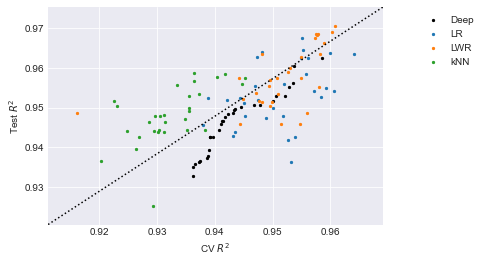

In [11]:
#rank our models on test_set 
from scipy.stats import linregress
from sklearn.metrics import r2_score

fig, ax = plt.subplots()


ax.scatter(x=scores_cv_deep["R2"], y=scores_test_deep["R2"], s=5,c="black",label=f"Deep")
ax.scatter(x=scores_cv_lr["R2"], y=scores_test_lr["R2"], s=5,label=f"LR")
ax.scatter(x=scores_cv_lwr["R2"], y=scores_test_lwr["R2"], s=5,label=f"LWR")
ax.scatter(x=scores_cv_knn["R2"], y=scores_test_knn["R2"], s=5,label=f"kNN")

# plot residuals
ax.legend(loc='upper right' , bbox_to_anchor=(1.3, 1))
ax.set_xlabel(r"CV $R^2$")
ax.set_ylabel(r"Test $R^2$")
#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
ax.axline([ax.get_xlim()[0], ax.get_ylim()[0]], [ax.get_xlim()[1], ax.get_ylim()[1]],c="black",linestyle=":")
#ax.set_yscale("symlog")
#ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(base_dir/f"prod_compare_{dataset_name}.png", bbox_inches='tight')